In [355]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import make_scorer, f1_score, classification_report

In [356]:
# Load DataFrame
df = pd.read_csv('FSFE_data.csv')

In [357]:
# Display DataFrame
df

,Mouth_Open_mean,Mouth_Open_std,Mouth_Open_skew,Mouth_Open_median,Mouth_Open_range,Mouth_Closed_mean,Mouth_Closed_std,Mouth_Closed_skew,Mouth_Closed_median,Mouth_Closed_range,...,Scared_skew,Scared_median,Scared_range,Disgusted_mean,Disgusted_std,Disgusted_skew,Disgusted_median,Disgusted_range,Artificiality,Expressiveness
0,0.001626,0.040292,24.740678,0.0,1,0.998374,0.040292,-24.740678,1.0,1,...,0.987182,0.042938,0.215839,0.017396,0.027293,1.762431,0.001511,0.149280,2,1
1,0.000000,0.000000,0.000000,0.0,0,1.000000,0.000000,0.000000,1.0,0,...,2.690334,0.025008,0.258095,0.001930,0.003207,6.252318,0.001025,0.064629,2,1
2,0.000000,0.000000,0.000000,0.0,0,1.000000,0.000000,0.000000,1.0,0,...,3.057499,0.001267,0.022736,0.020061,0.017527,4.511908,0.016444,0.238177,2,1
3,0.000055,0.007412,134.914788,0.0,1,0.999945,0.007412,-134.914788,1.0,1,...,6.393197,0.000325,0.026512,0.001943,0.005611,23.336876,0.001072,0.249527,2,1
4,0.001260,0.035469,28.125509,0.0,1,0.998740,0.035469,-28.125509,1.0,1,...,5.105870,0.000587,0.020964,0.007297,0.007052,5.976610,0.005617,0.144335,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.008999,0.094439,10.399382,0.0,1,0.991001,0.094439,-10.399382,1.0,1,...,5.848390,0.000865,0.025217,0.003897,0.004113,7.717646,0.003227,0.058343,1,2
76,0.000000,0.000000,0.000000,0.0,0,1.000000,0.000000,0.000000,1.0,0,...,1.966077,0.001292,0.009677,0.051939,0.035915,0.661456,0.046638,0.261266,1,2
77,0.000000,0.000000,0.000000,0.0,0,1.000000,0.000000,0.000000,1.0,0,...,2.964626,0.031134,0.203770,0.006393,0.004005,1.805111,0.005583,0.044648,1,2
78,0.000000,0.000000,0.000000,0.0,0,1.000000,0.000000,0.000000,1.0,0,...,1.710922,0.021423,0.165883,0.003480,0.002747,4.025735,0.002853,0.063627,1,2


In [358]:
# Extract features by dropping target columns from the DataFrame
X = df.drop(['Expressiveness','Artificiality'], axis=1)  
# Extract target variable 'Expressiveness' from the DataFrame
y = df['Expressiveness'] 

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [359]:
# Initialize the pipeline
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selector', RFECV(estimator=LogisticRegression(penalty='l2', random_state=42), 
                               step=1, 
                               cv=StratifiedKFold(5), 
                               scoring='f1')),
    ('classifier', LogisticRegression(penalty='l2', random_state=42, max_iter=1000))
])

# Define the parameter grid
param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1],
    'feature_selector__estimator__C': [0.01, 0.1, 1]
}

# Create inner and outer CV
outer_cv_lr = StratifiedKFold(n_splits=5)
inner_cv_lr = StratifiedKFold(n_splits=10)

# Create the Grid Search estimator
clf_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=inner_cv_lr, scoring='f1', n_jobs=-1)

# Calculate the generalization error using F1
nested_score_lr = cross_val_score(clf_lr, X=X_train, y=y_train, cv=outer_cv_lr, scoring='f1')
print(
    "The mean score using nested cross-validation is: "
    f"{nested_score_lr.mean():.3f} ± {nested_score_lr.std():.3f}"
)

# Fit Grid Search estimator to find best hyperparameters
clf_lr.fit(X_train, y_train)

# Extract the best hyperparameters
best_hyperparams = clf_lr.best_params_
print("Best hyperparameters:", best_hyperparams)

# Create new pipeline with the best hyperparameters
final_pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selector', RFECV(estimator=LogisticRegression(penalty='l2', random_state=42, C=best_hyperparams['feature_selector__estimator__C']), 
                               step=1, 
                               cv=StratifiedKFold(5), 
                               scoring='f1')),
    ('classifier', LogisticRegression(penalty='l2', random_state=42, max_iter=1000, C=best_hyperparams['classifier__C']))
])

# Train the final model on the entire training set
final_pipeline_lr.fit(X_train, y_train)

# Make predictions using the final estimator
y_train_pred_lr = final_pipeline_lr.predict(X_train)
y_test_pred_lr = final_pipeline_lr.predict(X_test)

# Evaluation using the final estimator
f1_train_lr = f1_score(y_train, y_train_pred_lr, average='weighted')
f1_test_lr = f1_score(y_test, y_test_pred_lr, average='weighted')

# Output final F1 scores
print(f"F1 Score on training data: {f1_train_lr}")
print(f"F1 Score on test data: {f1_test_lr}")

# Output classification reports
print("Classification Report for Training Data (LR):")
print(classification_report(y_train, y_train_pred_lr))
print("Classification Report for Test Data (LR):")
print(classification_report(y_test, y_test_pred_lr))

The mean score using nested cross-validation is: 0.511 ± 0.123
Best hyperparameters: {'classifier__C': 0.01, 'feature_selector__estimator__C': 0.01}
F1 Score on training data: 0.6559139784946237
F1 Score on test data: 0.43529411764705883
Classification Report for Training Data (LR):
              precision    recall  f1-score   support

           1       0.65      0.69      0.67        32
           2       0.67      0.62      0.65        32

    accuracy                           0.66        64
   macro avg       0.66      0.66      0.66        64
weighted avg       0.66      0.66      0.66        64

Classification Report for Test Data (LR):
              precision    recall  f1-score   support

           1       0.43      0.38      0.40         8
           2       0.44      0.50      0.47         8

    accuracy                           0.44        16
   macro avg       0.44      0.44      0.44        16
weighted avg       0.44      0.44      0.44        16



Number of features selected by RFECV: 12
                        Feature  Coefficient
1           Left Eye_Closed_std    -0.070600
0             Left Eye_Open_std    -0.070600
7                     Happy_std    -0.061683
6                    Happy_mean    -0.056169
9                Surprised_mean     0.051352
11             Surprised_median     0.044647
2    Left Eyebrow_Neutral_range     0.044289
3    Left Eyebrow_Lowered_range     0.044289
4   Right Eyebrow_Neutral_range     0.044289
5   Right Eyebrow_Lowered_range     0.044289
10                Surprised_std     0.043386
8                    Angry_skew    -0.043048


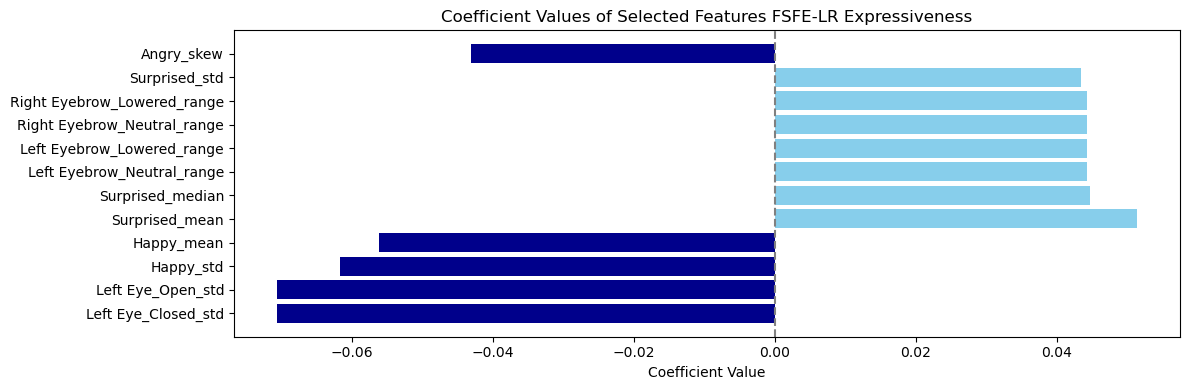

In [360]:
# Extract feature names
feature_names = X_train.columns

# Extract the boolean mask of selected features from RFECV
selected_features_mask_lr = final_pipeline_lr.named_steps['feature_selector'].support_

# Get the list of selected feature names
selected_feature_names_lr = feature_names[selected_features_mask_lr]

# Extract the coefficients from the LR model
coefficients_lr = final_pipeline_lr.named_steps['classifier'].coef_.flatten()

# Create a DataFrame to display the features and their coefficients
features_coefficients_df_lr = pd.DataFrame({
    'Feature': selected_feature_names_lr,
    'Coefficient': coefficients_lr
})

# Sort the DataFrame by the absolute values of the coefficients
features_coefficients_df_lr = features_coefficients_df_lr.reindex(
    features_coefficients_df_lr.Coefficient.abs().sort_values(ascending=False).index
)

# Printing the number of features selected and the DataFrame
n_features_selected_lr = sum(selected_features_mask_lr)
print("Number of features selected by RFECV:", n_features_selected_lr)
print(features_coefficients_df_lr)

# Save the DataFrame to a CSV file
features_coefficients_df_lr.to_csv('FSFE_Expressiveness_Feature_Coefficients_LR.csv', index=False)

# Define colors based on the sign of the coefficients
colors = ['darkblue' if x < 0 else 'skyblue' for x in features_coefficients_df_lr['Coefficient']]

# Plotting the coefficients with the specified colors
plt.figure(figsize=(12, 4))
plt.barh(
    range(len(features_coefficients_df_lr)),
    features_coefficients_df_lr['Coefficient'],
    color=colors
)
plt.yticks(
    range(len(features_coefficients_df_lr)),
    features_coefficients_df_lr['Feature']
)
plt.xlabel('Coefficient Value')
plt.title('Coefficient Values of Selected Features FSFE-LR Expressiveness')
plt.axvline(x=0, color='grey', linestyle='--')

# Show the plot
plt.tight_layout()
plt.show()

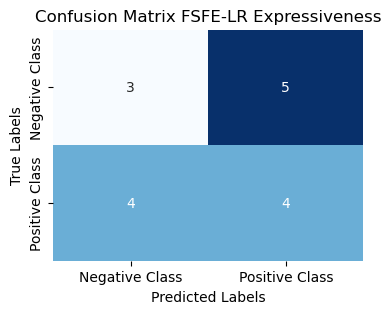

In [361]:
# Calculate the confusion matrix for the test data
cm_lr = confusion_matrix(y_test, y_test_pred_lr)

# Plotting the confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm_lr, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title('Confusion Matrix FSFE-LR Expressiveness')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(ticks=[0.5, 1.5], labels=['Negative Class', 'Positive Class'])
plt.yticks(ticks=[0.5, 1.5], labels=['Negative Class', 'Positive Class'], va='center')
plt.show()

In [362]:
# Initialize the pipeline
pipeline_svc = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selector', RFECV(estimator=SVC(kernel='linear', random_state=42), 
                               step=1, 
                               cv=StratifiedKFold(5), 
                               scoring='f1')),
    ('classifier', SVC(kernel='linear', random_state=42))
])

# Define the parameter grid
param_grid_svc = {
    'classifier__C': [0.01, 0.1, 1],
    'feature_selector__estimator__C': [0.1, 1, 10]
}

# Create inner and outer CV
outer_cv_svc = StratifiedKFold(n_splits=5)
inner_cv_svc = StratifiedKFold(n_splits=10)

# Create the Grid Search estimator
clf_svc = GridSearchCV(pipeline_svc, param_grid_svc, cv=inner_cv_svc, scoring='f1', n_jobs=-1)

# Calculate the generalization error using F1
nested_score_svc = cross_val_score(clf_svc, X=X_train, y=y_train, cv=outer_cv_svc, scoring='f1')
print(
    "The mean score using nested cross-validation for SVC is: "
    f"{nested_score_svc.mean():.3f} ± {nested_score_svc.std():.3f}"
)

# Fit Grid Search estimator to find best hyperparameters
clf_svc.fit(X_train, y_train)

# Extract the best hyperparameters
best_hyperparams_svc = clf_svc.best_params_
print("Best hyperparameters for SVC:", best_hyperparams_svc)

# Create a new pipeline with the best hyperparameters
final_pipeline_svc = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selector', RFECV(estimator=SVC(kernel='linear', random_state=42, C=best_hyperparams_svc['feature_selector__estimator__C']), 
                               step=1, 
                               cv=StratifiedKFold(5), 
                               scoring='f1')),
    ('classifier', SVC(kernel='linear', random_state=42, C=best_hyperparams_svc['classifier__C']))
])

# Train the final model on the entire training set
final_pipeline_svc.fit(X_train, y_train)

# Make predictions using the final estimator
y_train_pred_svc = final_pipeline_svc.predict(X_train)
y_test_pred_svc = final_pipeline_svc.predict(X_test)

# Evaluation using the final estimator
f1_train_svc = f1_score(y_train, y_train_pred_svc, average='weighted')
f1_test_svc = f1_score(y_test, y_test_pred_svc, average='weighted')

# Output final F1 scores
print(f"F1 Score on training data (SVC): {f1_train_svc}")
print(f"F1 Score on test data (SVC): {f1_test_svc}")

# Output classification reports
print("Classification Report for Training Data (SVC):")
print(classification_report(y_train, y_train_pred_svc))
print("Classification Report for Test Data (SVC):")
print(classification_report(y_test, y_test_pred_svc))

The mean score using nested cross-validation for SVC is: 0.417 ± 0.228
Best hyperparameters for SVC: {'classifier__C': 1, 'feature_selector__estimator__C': 10}
F1 Score on training data (SVC): 0.8905982905982905
F1 Score on test data (SVC): 0.75
Classification Report for Training Data (SVC):
              precision    recall  f1-score   support

           1       0.90      0.88      0.89        32
           2       0.88      0.91      0.89        32

    accuracy                           0.89        64
   macro avg       0.89      0.89      0.89        64
weighted avg       0.89      0.89      0.89        64

Classification Report for Test Data (SVC):
              precision    recall  f1-score   support

           1       0.75      0.75      0.75         8
           2       0.75      0.75      0.75         8

    accuracy                           0.75        16
   macro avg       0.75      0.75      0.75        16
weighted avg       0.75      0.75      0.75        16



Number of features selected by RFECV: 26
                        Feature  Coefficient
15                    Happy_std    -1.496190
6      Left Eyebrow_Raised_mean     1.250889
18                    Sad_range     1.134377
16                  Happy_range     1.007918
24                   Scared_std    -0.995225
20                   Angry_skew    -0.813136
9      Left Eyebrow_Lowered_std    -0.700841
23             Surprised_median     0.653621
2        Left Eye_Closed_median     0.629830
1           Left Eye_Closed_std    -0.605291
0             Left Eye_Open_std    -0.605291
17                     Sad_mean    -0.586954
13   Right Eyebrow_Lowered_skew    -0.576118
19                    Angry_std    -0.503042
25                Scared_median     0.375051
4      Left Eyebrow_Neutral_std    -0.353196
14  Right Eyebrow_Lowered_range     0.349369
11  Right Eyebrow_Neutral_range     0.349369
10   Left Eyebrow_Lowered_range     0.349369
5    Left Eyebrow_Neutral_range     0.349369
22            

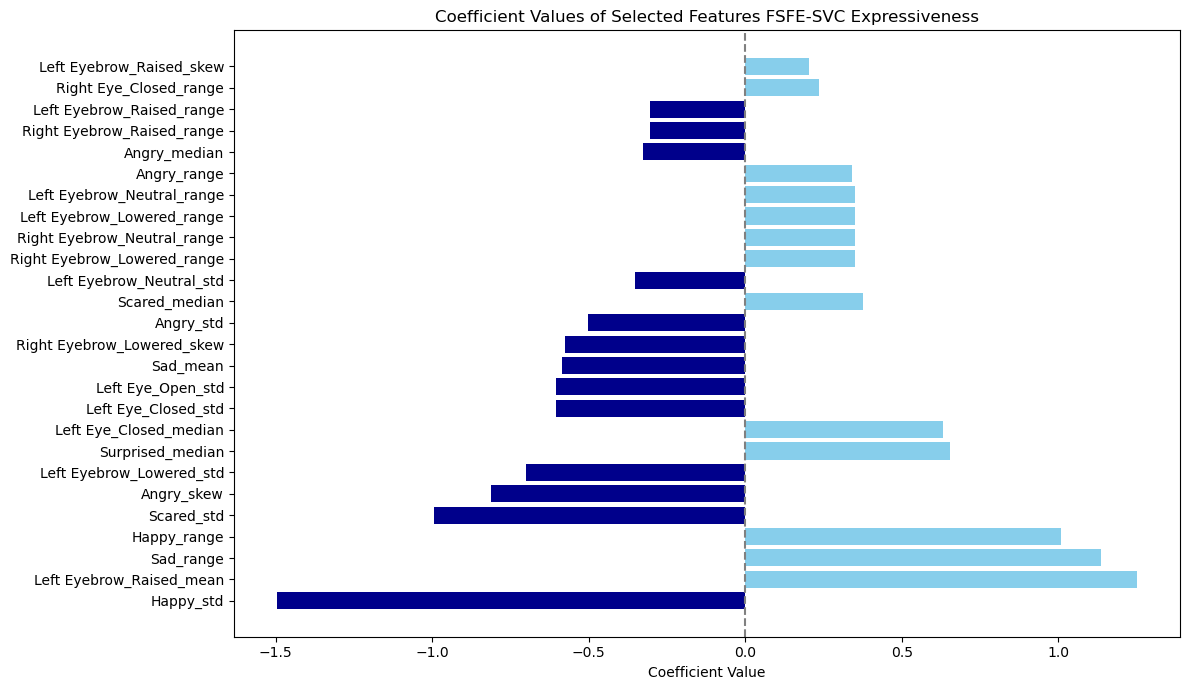

In [363]:
# Extract feature names
feature_names = X_train.columns

# Extract the boolean mask of selected features from RFECV
selected_features_mask_svc = final_pipeline_svc.named_steps['feature_selector'].support_

# Get the list of selected feature names
selected_feature_names_svc = feature_names[selected_features_mask_svc]

# Extract the coefficients from the SVC model
coefficients_svc = final_pipeline_svc.named_steps['classifier'].coef_.flatten()

# Create a DataFrame to display the features and their coefficients
features_coefficients_df_svc = pd.DataFrame({
    'Feature': selected_feature_names_svc,
    'Coefficient': coefficients_svc
})

# Sort the DataFrame by the absolute values of the coefficients
features_coefficients_df_svc = features_coefficients_df_svc.reindex(
    features_coefficients_df_svc.Coefficient.abs().sort_values(ascending=False).index
)

# Printing the number of features selected and the DataFrame
n_features_selected_svc = sum(selected_features_mask_svc)
print("Number of features selected by RFECV:", n_features_selected_svc)
print(features_coefficients_df_svc)

# Save the DataFrame to a CSV file
features_coefficients_df_svc.to_csv('FSFE_Expressiveness_Feature_Coefficients_SVC.csv', index=False)

# Define colors based on the sign of the coefficients
colors_svc = ['darkblue' if x < 0 else 'skyblue' for x in features_coefficients_df_svc['Coefficient']]

# Plotting the coefficients with the specified colors
plt.figure(figsize=(12, 7))
plt.barh(
    range(len(features_coefficients_df_svc)),
    features_coefficients_df_svc['Coefficient'],
    color=colors_svc
)
plt.yticks(
    range(len(features_coefficients_df_svc)),
    features_coefficients_df_svc['Feature']
)
plt.xlabel('Coefficient Value')
plt.title('Coefficient Values of Selected Features FSFE-SVC Expressiveness')
plt.axvline(x=0, color='grey', linestyle='--')

# Show the plot
plt.tight_layout()
plt.show()

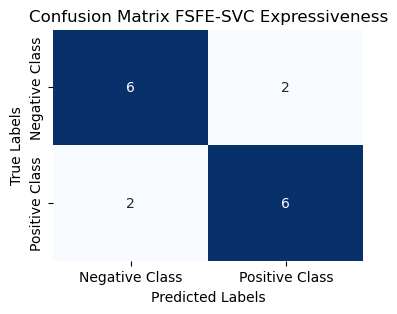

In [364]:
# Calculate the confusion matrix for the test data
cm_svc = confusion_matrix(y_test, y_test_pred_svc)

# Plotting the confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm_svc, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title('Confusion Matrix FSFE-SVC Expressiveness')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(ticks=[0.5, 1.5], labels=['Negative Class', 'Positive Class'])
plt.yticks(ticks=[0.5, 1.5], labels=['Negative Class', 'Positive Class'], va='center')
plt.show()